## 1 Data (metadata + fulltexts) from e-rara website

### 1.0 Prerequisites

In [1]:
# Import the necessary Python libraries
import os     # for navigating the machine (e.g., file directories)
from datetime import datetime       # for working with dates and time
import codecs     # for encodings
import requests     # for requesting URLs
from bs4 import BeautifulSoup as soup     # for webscraping, parsing HTML and XML
import json     # module for working with JSON data structures
import pandas as pd       # module for general data processing, esp. dataframes
import re     # for using regular expressions
print("Succesfully imported necessary modules")

Succesfully imported necessary modules


In [2]:
# Enable file up- and download to/from local machine
from google.colab import files
import io

In [3]:
# Enable file up- and download to/from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_e_rara_items(coll_name, date):
  '''
  Function to load e_rara item file from local machine into dataframe "items"
  '''
  uploaded = files.upload()
  infile = coll_name + "_items_ocr_ger_{}.csv".format(date) 
  with open(infile, "r") as f:
      pd.read_csv(f)
  global items
  items = pd.read_csv("/content/" + infile)
  print("Dataframe 'items' with " + str(len(items)) + " rows loaded from " + infile)


In [ ]:
 def load_e_rara_sets(date):
  '''
  Function to load e_rara sets file from local machine into dataframe "e_rara_sets"
  '''
  uploaded = files.upload()
  infile = "e_rara_sets_{}.csv".format(date)
  with open(infile, "r") as f:
      pd.read_csv(f)
  global e_rara_sets
  e_rara_sets = pd.read_csv("/content/" + infile)
  print("Dataframe 'e_rara_sets' with " + str(len(e_rara_sets)) + " rows loaded from " + infile)


In [ ]:
# Information about e-rara collections manually collected from website
# FULL collection sizes (all formats, all languages, incl. non-OCR)

e_rara_coll_full = pd.DataFrame(
    {'coll_name': ['ch20', 'ch19', 'ch18', 'ch17', 'ch16', 'ch15', 'bernensia'],
    'coll_id': [15355294, 2464076, 1655618, 1655617, 40, 1133852, 1395750],
    'coll_size': [480, 5410, 6589, 10215, 7524, 464, 519]})

e_rara_coll_full

,coll_name,coll_id,coll_size
0,ch20,15355294,480
1,ch19,2464076,5410
2,ch18,1655618,6589
3,ch17,1655617,10215
4,ch16,40,7524
5,ch15,1133852,464
6,bernensia,1395750,519


In [ ]:
# Information about e-rara collections manually collected from website (last: 2021-02-27)
# Collections sizes with active filters «Fulltext + «Book» + «German»

e_rara_coll = pd.DataFrame(
    {'coll_name': ['ch20', 'ch19', 'ch18', 'ch17', 'ch16', 'bernensia'],
    'coll_id': [15355294, 2464076, 1655618, 1655617, 40, 1395750],
    'coll_size': [98, 3001, 663, 3, 2, 176]})

e_rara_coll

,coll_name,coll_id,coll_size
0,ch20,15355294,98
1,ch19,2464076,3001
2,ch18,1655618,663
3,ch17,1655617,3
4,ch16,40,2
5,bernensia,1395750,176


### 0.1 From e-rara website: Find collection items
Script to find items on e-rara website according to their collection, get and save a csv file of items with their links to local machine.

In [ ]:
def find_e_rara_items(coll_name):
    '''
    Function to 
    * call an e_rara collection and scraping its results pages
    * retrieve the e_rara item IDs, their item page URLs and fulltext URLs
    * writes them into a csv-file "coll_name + _items_ocr_ger_ + date.csv" on local machine.
    '''
    # get the collection id and size according to parameter collection name
    coll_id = int(e_rara_coll[e_rara_coll['coll_name']==coll_name]['coll_id'])
    # coll_size = int(rara_coll[rara_coll['coll_name']==coll_name]['coll_size'])

    # base-URL of collection in e-rara with filters «Fulltext + «Book» + «German»
    baseurl = "https://www.e-rara.ch/nav/classification/{}?&facets=type%3D%22book%22%20and%20ftmode%3D%22ocr%22%20and%20language%3D%22ger%22&offset=".format(coll_id)
    response = requests.get(baseurl)
    soup_out = soup(response.text, 'html.parser')
    text = soup_out.find('span', class_='itemCount').text
    coll_size = int(re.search('(\d+)', text).group())
    
    offsets = list(range(11, coll_size, 10))
    offsets.insert(0, 1)
    offsets = map(str, offsets)

    items = pd.DataFrame(columns = ['e_rara_id', 'item_link', 'fulltext_link', 'offset', 'coll_name'])

    # construct webaddresses for search results, call them and scrape item IDs and URLs
    for offset in offsets:
        webadd = baseurl + offset
        response = requests.get(webadd) 
        # parse the results pages for the single items
        soup_out = soup(response.text, 'html.parser')

        for link in soup_out.find_all('a'):
            if "content/titleinfo" in str(link.get):
                item = link.get("href")
                                #e_rara_id = int(''.join(filter(str.isdigit, item)))   # variant discarded because...
                                #e_rara_id = str(e_rara_id)[1:]      # error with numbers like "bai_1" in item/link
                match = re.search('titleinfo\/(\d+)', item)     # selects number after "titleinfo/" 
                if match:
                    e_rara_id = match.group(1)     # first parenthesized subgroup = number
                items = items.append(
                    {'e_rara_id': e_rara_id,
                   'item_link': "https://www.e-rara.ch{}".format(item),
                   'fulltext_link': "https://www.e-rara.ch/download/fulltext/plain/{}".format(e_rara_id),
                   'offset': offset,
                   'coll_name': coll_name},
                   ignore_index=True)
                
    items = items.drop_duplicates()
    print("Collection: {}".format(coll_name))
    print("Collection size: {}".format(coll_size))
    print("Number of items retrieved: {}".format(len(items)))

    # save items to file
    date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
    outfile = "./" + coll_name + "_items_ocr_ger_" + date + ".csv"
    with open(outfile, "w") as f:
        items.to_csv(f, index=False)
        files.download(outfile)
    print("Saved to file ./{}_items_ocr_ger_{}.csv to local machine.".format(coll_name, date))

    # save file to Google Drive
    %cd /content/drive/My\ Drive/e_rara_fulltexts
    outfile = "./" + coll_name + "_items_ocr_ger_" + date + ".csv"
    with open(outfile, "w") as f:
        items.to_csv(f, index=False)
        files.download(outfile)
    %cd /content/
    print("Saved to file ./{}_items_ocr_ger_{}.csv to Google Drive.".format(coll_name, date))

In [ ]:
find_e_rara_items("ch20")

Collection: ch20
Collection size: 98
Number of items retrieved: 98


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to file ./ch20_items_ocr_ger_2021-02-27.csv to local machine.
/content/drive/My Drive/e_rara_fulltexts


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
Saved to file ./ch20_items_ocr_ger_2021-02-27.csv to Google Drive.


In [ ]:
# Get collection size out of e-rara website

#baseurl = "https://www.e-rara.ch/nav/classification/1395750?&facets=type%3D%22book%22%20and%20ftmode%3D%22ocr%22%20and%20language%3D%22ger%22"
baseurl = 'https://www.e-rara.ch/nav/classification/1395750?&facets=type="book" and ftmode="ocr" and language="ger" and d100="1900"'
webadd = baseurl
response = requests.get(webadd)
soup_out = soup(response.text, 'html.parser')
#soup_out.find("a", href=True)["href"] 
text = soup_out.find('span', class_='itemCount').text
re.search('(\d+)', text).group()

'42'

In [ ]:
# in development

def get_erara_items_1(coll_name, doctype="book", ocr="ocr", language="ger"):
    baseurl = 'https://www.e-rara.ch/nav/classification/{}' + '?&facets=type%3D%22' + $doctype + '%22%20and%20ftmode%3D%22' + $ocr + '%22%20and%20language%3D%22' + $language + '%22'.format(coll_name)
    #baseurl = 'https://www.e-rara.ch/nav/classification/{}?&facets=type="$doctype" and ftmode="$ocr" and language="$language"'.format(coll_name)
    webadd = baseurl
    response = requests.get(webadd)
    soup_out = soup(response.text, 'html.parser')
    #soup_out.find("a", href=True)["href"] 
    text = soup_out.find('span', class_='itemCount').text
    re.search('(\d+)', text).group()
get_erara_items_1("1395750")

In [ ]:
# Unfortunately params methods doesn't work
baseurl = "https://www.e-rara.ch/nav/classification/{}?&facets=".format(2464076)
params = {'type=': "book", 'ftmode=': "ocr", 'language=': "ger"}
response = requests.get(baseurl, params=params)
soup_out = soup(response.text, 'html.parser')
soup_out.find('span', class_='itemCount').text

### 0.2 Load item file from local machine into dataframe "items"

In [ ]:
def load_e_rara_items(coll_name, date):
  '''
  Function to load e_rara item file from local machine into dataframe "items"
  '''
  uploaded = files.upload()
  infile = coll_name + "_items_ocr_ger_{}.csv".format(date) 
  with open(infile, "r") as f:
      pd.read_csv(f)
  global items
  items = pd.read_csv("/content/" + infile)
  print("Dataframe 'items' with " + str(len(items)) + " rows loaded from " + infile)


In [ ]:
load_e_rara_items("bernensia", "2021-02-27")

Saving bernensia_items_ocr_ger_2021-02-27.csv to bernensia_items_ocr_ger_2021-02-27 (1).csv
Dataframe 'items' with 176 rows loaded from bernensia_items_ocr_ger_2021-02-27.csv


In [ ]:
# small set of e-rara IDs and fulltext links for testing
print(list(items["e_rara_id"][0:5]))
print(list(items["fulltext_link"][0:5]))

# define list "e_rara_ids"
e_rara_ids = list(items["e_rara_id"][0:len(items)])   
e_rara_ids = list(map(str, e_rara_ids))
print(len(e_rara_ids))

# define list "e_rara_fulltext_links"
e_rara_fulltext_links = list(items["fulltext_link"][0:len(items)]) 
e_rara_fulltext_links = list(map(str, e_rara_fulltext_links))
print(len(e_rara_fulltext_links))


[14432690, 1757509, 1397203, 16830696, 9119958]
['https://www.e-rara.ch/bes_1/download/fulltext/plain/14432690', 'https://www.e-rara.ch/bes_1/download/fulltext/plain/1757509', 'https://www.e-rara.ch/bes_1/download/fulltext/plain/1397203', 'https://www.e-rara.ch/bes_1/download/fulltext/plain/16830696', 'https://www.e-rara.ch/bes_1/download/fulltext/plain/9119958']
176
176


### 0.3 From e-rara website: Download fulltexts 
Script to download fulltext files from e-rara website with e-rara IDs according to local item file.

In [ ]:
def get_e_rara_fulltexts(coll_name, split_start = 0, split_end = len(items)):
    '''
    Function to retrieve fulltexts from e_rara:
    * builds upon "items" dataframe
    * selects e-rara IDs from "items" according to the given start and end split
    * builds with e-rara IDs the fulltext URLs 
    * creates the following folder path in Google Drive: e_rara_fulltexts > collection name > ger
    * reads the txt files and writes them in separate txt files in created folder
    * prints output.
    '''
    load_e_rara_items(coll_name, "2021-02-27")
    e_rara_ids = list(items["e_rara_id"][split_start:split_end])  
    e_rara_ids = list(map(str, e_rara_ids))

    # base URL of e-rara fulltexts
    baseurl_fulltext = "https://www.e-rara.ch/download/fulltext/plain/"
    count = 0

    # create folder path in Google Drive
    %cd /content/drive/My\ Drive
    !mkdir -p -- e_rara_fulltexts/$coll_name/ger
    %cd /content/

    for e_rara_id in e_rara_ids:
        webadd = baseurl_fulltext + e_rara_id
        response = requests.get(webadd) 
        soup_out = soup(response.text, 'html.parser')
        
        # save to file to Google Drive - save to local machine would evoke file explorer for each file
        # later maybe: zip-file to local machine
        outfile = "/content/drive/My Drive/e_rara_fulltexts/{}/ger/".format(coll_name) + e_rara_id + ".txt"
        try:
            with open(outfile, 'x') as f:
                f.write(soup_out.get_text())
            count += 1
        except FileExistsError:
            print("Fulltext file " + e_rara_id + ".txt exists already.")
        except:
            print("Saving fulltext file " + e_rara_id + ".txt failed.")
        finally:
            pass
        
        
    print("{} of {} fulltexts saved to Google Drive.".format(count, len(e_rara_ids)))

In [ ]:
get_e_rara_fulltexts("ch17")

Saving ch17_items_ocr_ger_2021-02-27.csv to ch17_items_ocr_ger_2021-02-27 (1).csv
Dataframe 'items' with 3 rows loaded from ch17_items_ocr_ger_2021-02-27.csv
/content/drive/My Drive
/content
3 of 3 fulltexts saved to Google Drive.


## 2 Metadata from OAI-PMH interface

In [ ]:
# Load the necessary modules
import requests
from bs4 import BeautifulSoup as soup
import lxml
import math
import concurrent.futures
import re
import time
print("Succesfully imported necessary modules")

Succesfully imported necessary modules


### 2.0 OAI-PMH

OAI example requests look like:
- ListMetadataFormats: https://www.e-rara.ch/bes_1/oai?verb=ListMetadataFormats
    - oai_dc, mets, mods, rawmods, epicur
- ListSets: https://www.e-rara.ch/bes_1/oai?verb=ListSets
- ListIdentifiers:
https://www.e-rara.ch/bes_1/oai?verb=ListIdentifiers&metadataPrefix=mods&set=bernensia
- GetRecords (certain record):
https://www.e-rara.ch/bes_1/oai?verb=GetRecord&metadataPrefix=mods&identifier=23216296 
-GetRecords (list of records):
https://www.e-rara.ch/bes_1/oai?verb=ListRecords&from=1900-01-01&set=bernensia&metadataPrefix=oai_dc

In [ ]:
# example for accessing OAI interface
base_url = 'https://www.e-rara.ch/oai?'
xml_soup = download_xml({'verb': 'ListIdentifiers', 'set': 'newspaper', 'metadataPrefix': 'oai_dc'})
xml_soup

<html><body><oai-pmh xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd"><responsedate>2021-02-23T09:14:11Z</responsedate><request metadataprefix="oai_dc" set="newspaper" verb="ListIdentifiers">https://www.e-rara.ch/bes_1/oai/</request><listidentifiers><header><identifier>oai:www.e-rara.ch/bes_1:13620240</identifier><datestamp>2016-11-01T14:06:35Z</datestamp><setspec>bes_1</setspec><setspec>newspaper</setspec><setspec>collections</setspec><setspec>russexil</setspec></header><header><identifier>oai:www.e-rara.ch/bes_1:13620269</identifier><datestamp>2016-12-16T12:13:44Z</datestamp><setspec>bes_1</setspec><setspec>newspaper</setspec><setspec>collections</setspec><setspec>russexil</setspec></header><header><identifier>oai:www.e-rara.ch/bes_1:13620320</identifier><datestamp>2016-11-01T15:39:13Z</datestamp><setspec>bes_1</setspec><setspec>n

### 2.1 Inspect collection data via OAI-PMH sets

In [ ]:
def download_xml(params):
    '''
    Accesses the OAI sites and scrapes its HTML/XML content.
    '''
    response = requests.get(base_url, params=params)
    output_soup = soup(response.content, "lxml")
    return output_soup

In [ ]:
# What sets (collections) are available via e-rara OAI?

def get_e_rara_sets():
    '''
    Scrapes the e-rara set data which is available via OAI-PMH.
    Uses ListSets and ListIdentifiers method to retrieve setName, setSpec and setSize
    and writes them into a "e_rara_sets.csv" file.
    Data example:
        setName: Kantonsbibliothek Graubünden
        setSpec: kbg
        setSize: 208
    '''

    base_url = 'https://www.e-rara.ch/oai?'
    setsearch_term = {'verb': 'ListSets'}

    def download_xml(params):
        '''
        Accesses the OAI sites and scrapes its HTML/XML content.
        '''
        response = requests.get(base_url, params=params)
        output_soup = soup(response.content, "lxml")
        return output_soup

    print("Retrieving the sets via ListSets method...")

    # Start with the first access to OAI interface
    output_soup = download_xml(setsearch_term)
    e_rara_sets = pd.DataFrame(columns = ['setName', 'setSpec'])

    # Scraping out the e-rara sets of the first page
    e_rara_sets.setName = [(i.contents[0]) for i in output_soup.find_all('setname')]
    e_rara_sets.setSpec = [(i.contents[0]) for i in output_soup.find_all('setspec')]
    resumption_token = output_soup.find('resumptiontoken').get_text()

    while resumption_token != None:
        print('Accessing resumption token:', resumption_token)
        output_soup = download_xml({'verb': 'ListSets', 'resumptionToken': resumption_token})
        # Scraping out the e-rara sets
        setnames = [(i.contents[0]) for i in output_soup.find_all('setname')]
        setspecs = [(i.contents[0]) for i in output_soup.find_all('setspec')]
        df = pd.DataFrame()
        df['setName'] = setnames
        df['setSpec'] = setspecs
        e_rara_sets = e_rara_sets.append(df, ignore_index=True)

        # Actualize the resumption token to retrieve the the next page
        try:
            new_token = output_soup.find('resumptiontoken').get_text()
            resumption_token = new_token
        except AttributeError:
            resumption_token = None
            print('Reached end of sets/results list')       # notice when last page is done
        finally:
            pass

    # Get the sizes of the OAI sets (collections) and bind them into e_rara_sets file.
    # Empty sets return "noRecordsMatch" and get a size of 0
    print("Retrieving the set sizes via ListIdentifiers method...")
    e_rara_sets['setSize'] = 0

    for i, setSpec in enumerate(e_rara_sets.setSpec):
        xml_soup = download_xml({'verb': 'ListIdentifiers', 'set': setSpec, 'metadataPrefix': 'oai_dc'})
        if xml_soup.resumptiontoken:
            size = xml_soup.resumptiontoken['completelistsize']
        elif xml_soup.error:
            size = xml_soup.error['code']
        else: size = len(xml_soup.find_all('identifier'))
        e_rara_sets.setSize[i] = size
    e_rara_sets.setSize[e_rara_sets.setSize == 'noRecordsMatch'] = 0

    # Save e_rara_sets file to local machine
    date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
    outfile = "./e_rara_sets_" + date + ".csv"
    with open(outfile, "w", encoding="utf-8") as f:
        e_rara_sets.to_csv(f, index=False)
        files.download(outfile)
        print("Saved to file ./e_rara_sets_{}.csv to local machine.".format(date))

    # save e_rara_sets file to Google Drive
    %cd /content/drive/My\ Drive/e_rara_metadata
    outfile = "./e_rara_sets_" + date + ".csv"
    with open(outfile, "w") as f:
        e_rara_sets.to_csv(f, index=False)
        files.download(outfile)
    %cd /content/
    print("Saved to file ./e_rara_sets_{}.csv to Google Drive.".format(date))

    return e_rara_sets

In [ ]:
get_e_rara_sets()

Retrieving the sets via ListSets method...
Accessing resumption token: cursor_p_3D10_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D20_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D30_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D40_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D50_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D60_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D70_p_26batch_size_p_3D11
Accessing resumption token: cursor_p_3D80_p_26batch_size_p_3D11
Reached end of sets/results list
Retrieving the set sizes via ListIdentifiers method...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to file ./e_rara_sets_2021-02-27.csv to local machine.
/content/drive/My Drive/e_rara_metadata


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
Saved to file ./e_rara_sets_2021-02-27.csv to Google Drive.


,setName,setSpec,setSize
0,BCU Fribourg (GLN),frc_g,0
1,Alle Bibliotheken,elibch,0
2,Zentralbibliothek Solothurn,zbs,77
3,Stadtbibliothek Schaffhausen,sbs,68
4,Astronomie-rara,astrorara,0
...,...,...,...
76,unknown spec,doi,84320
77,notated music,notated_music,735
78,book,book,59469
79,illustration document,illustration_document,17333


In [ ]:
load_e_rara_sets("2021-02-27")

Saving e_rara_sets_2021-02-27.csv to e_rara_sets_2021-02-27 (1).csv
Dataframe 'e_rara_sets' with 81 rows loaded from e_rara_sets_2021-02-27.csv


In [ ]:
# empty OAI sets
e_rara_sets[e_rara_sets.setSize == 0]

,setName,setSpec,setSize
0,BCU Fribourg (GLN),frc_g,0
1,Alle Bibliotheken,elibch,0
4,Astronomie-rara,astrorara,0
8,ETH-Bibliothek Zürich,astrozut,0
14,"Institut et Musée Voltaire, Genève",ge88,0
34,e-rara,erara,0


In [ ]:
# non-empty OAI sets, in descending order of size
e_rara_sets[e_rara_sets.setSize != 0].sort_values(by=['setSize'], ascending=False).style

,setName,setSpec,setSize
76,unknown spec,doi,84320
78,book,book,59469
54,Themen und Sammlungen,collections,58750
31,ZB Zürich (NEBIS),zuz,38822
40,Schweizer Drucke,ch,30532
27,ETH-Bibliothek (NEBIS),zut,21096
65,Wissenschaftshistorische Bestände (ETH-Bibliothek),wihibe,19035
79,illustration document,illustration_document,17333
5,UB Basel (DSV01),bau_1,13050
41,Schweizer Drucke des 17. Jahrhunderts,ch17,10209


Comparing the sizes of OAI sets with collection from e-rara website.

In [ ]:
print("Collection sizes according to e-rara website:")
e_rara_coll_full

Collection sizes according to e-rara website:


,coll_name,coll_id,coll_size
0,20th_century,15355294,480
1,19th_century,2464076,5410
2,18th_century,1655618,6589
3,17th_century,1655617,10215
4,16th_century,40,7524
5,15th_century,1133852,464
6,bernensia,1395750,519


In [ ]:
print("Set sizes of the OAI-PMH inface:")
sets = ['ch20', 'ch19', 'ch18', 'ch17', 'ch16', 'ch15', 'bernensia']
for s in sets:
    print(s + " has records: " + str(int(e_rara_sets.setSize[e_rara_sets.setSpec == s])))

Set sizes of the OAI-PMH inface:
ch20 has records: 480
ch19 has records: 5368
ch18 has records: 6551
ch17 has records: 10209
ch16 has records: 7504
ch15 has records: 464
bernensia has records: 519


### 2.2 Download metadata files via OAI-PMH

In [ ]:
# Enable load and save from/to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For retrieving the OAI interface of e-rara a function needs to be defined. It will
1. Request to retrieve e-rara IDs according to set.
2. Retrieve the metadata of the items (MODS standard) and write them into single '.mods' files to Google Drive.

In [ ]:

def retrieve_OAI_metadata(set):
    '''
    Requests e-rara OAI-PMH interface according for a set to 
    * retrieve its e-rara IDs
    * retrieve metadata according to set e-rara IDs
    * writes metadata into single <e_rara_id>.mods files to Google Drive.
    '''

    # Set parameters to the interface
    base_url = 'https://www.e-rara.ch/oai?'
    recordsearch_term = {'verb': 'GetRecord', 'metadataPrefix': 'mods'}
    listsearch_term = {'verb': 'ListIdentifiers', 'metadataPrefix': 'mods', 'set': set}

    def download_xml(params):
        '''
        Accesses the OAI sites and scrapes its HTML/XML content.
        '''
        response = requests.get(base_url, params=params)
        output_soup = soup(response.content, "lxml")
        return output_soup

    def download_record(id):
        '''
        Downloads MODS metadata files from OAI to Google Drive.
        Throws a notice if metadata file already exists.
        '''
        output_soup = download_xml({'verb': 'GetRecord', 'metadataPrefix': 'mods', 'identifier': id})
        outfile = '/content/drive/My Drive/e_rara_metadata/{}/{}.mods'.format(set, id) 
        try:
            with open(outfile, mode='x', encoding='utf-8') as f:
                    f.write(output_soup.decode())
        except FileExistsError:
                print("Metadata file " + id + ".mods exists already.")
        finally:
                pass

    # Start with the first access to OAI interface - get the item IDs of a collection
    xml_soup = download_xml(listsearch_term)

    # Calculate how many accesses it takes to go through all the pages of the results list, print notice
    splits = math.ceil(int(xml_soup.resumptiontoken['completelistsize']) // 10) + 1
    print(xml_soup.resumptiontoken['completelistsize'], 'identifiers to request in ', splits, 'data splits')
    
    start = time.perf_counter()

    for i in range(splits):
        if i == 0:
            # first access for item IDs - first page + information about whole length of results list
            xml_soup_new = download_xml(listsearch_term)      
        else:
            # following accesses for item IDs
            xml_soup_new = download_xml({'verb': 'ListIdentifiers', 'resumptionToken': resumption_token})

        # Scraping out the e-rara IDs
        ids = [] 
        for id in [(i.contents[0]) for i in xml_soup_new.find_all('identifier')]:
            match = re.search('oai:www.e-rara.ch:(\d+)', id)      # extract the number following 'oai:www.e-rara.ch:'
            if match:
                ids.append(match.group(1))     # first parenthesized subgroup of group() = number

        # Download the MODS metadata records according to retrieved e-rara IDs
        print('Start retrieving metadata for e_rara_ids ', ids)  
        # with concurrent.futures.ProcessPoolExecutor() as executor:     
            # results = executor.map(download_record, ids)
        for id in ids:
            download_record(id)
        ids = []

        # Actualize the resumtpion token to retrieve the the next page
        try:
            new_token = xml_soup_new.find('resumptiontoken').get_text()
            resumption_token = new_token
            print('New resumption token:', resumption_token)
        except AttributeError:
            print('Reached end of IDs/results list')       # notice when last page is done
        finally:
            pass

    finish = time.perf_counter()

    print("Finished in {} second(s).".format(round(finish - start, 2)))

In [ ]:
retrieve_OAI_metadata("ch19")

5368 identifiers to request in  537 data splits
Start retrieving metadata for e_rara_ids  ['14017', '34616', '34628', '366308', '388892', '435271', '649605', '672521', '729101', '730609']
Metadata file 14017.mods exists already.
Metadata file 34616.mods exists already.
Metadata file 34628.mods exists already.
Metadata file 366308.mods exists already.
Metadata file 388892.mods exists already.
Metadata file 435271.mods exists already.
Metadata file 649605.mods exists already.
Metadata file 672521.mods exists already.
Metadata file 729101.mods exists already.
New resumption token: 0x4538da22d6a05ff4e18dbfe4798cdaf3-cursor_p_3D10_p_26set_p_3Dch19_p_26metadataPrefix_p_3Dmods_p_26batch_size_p_3D11
Start retrieving metadata for e_rara_ids  ['909944', '909984', '930098', '931662', '931862', '946948', '956727', '962258', '984491', '1002756']
New resumption token: 0xd797bb0db6a629092e0d0fbd645ff9e0-cursor_p_3D20_p_26set_p_3Dch19_p_26metadataPrefix_p_3Dmods_p_26batch_size_p_3D11
Start retrieving 

### 2.3 Parse MODS metadata files into dataframe

In [ ]:
# Enable file up- and download to/from local machine
from google.colab import files
import io

In [ ]:
# Enable file up- and download to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary modules
import requests
from datetime import datetime       # for working with dates and time
from bs4 import BeautifulSoup as soup
import lxml     # lxml’s XML parser is the only currently  by bs4 supported XML parser; call with soup(markup, 'lxml-xml' OR 'xml')
import json
import re
import pandas as pd

In [ ]:
# Alternative: Accessing directly the files on Google Drive
import os
from pathlib import Path
import glob

def check_metadata_fulltexts(set):
    with os.scandir('/content/drive/My Drive/e_rara_metadata/{}/'.format(set)) as entries:
        count = 0
        for entry in entries:
            count += 1
            #print(entry.name)
        print("Metadata files in '.../e_rara_metadata/'" + set + ": {}".format(count))

    with os.scandir('/content/drive/My Drive/e_rara_fulltexts/{}/ger/'.format(set)) as entries:
        count = 0
        for entry in entries:
            count += 1
            #print(entry.name)
        print("Fulltext files in '.../e_rara_fulltexts/" + set + "/ger/': {}".format(count))

In [ ]:
check_metadata_fulltexts("bernensia")

Metadata files in '.../e_rara_metadata/'bernensia: 519
Fulltext files in '.../e_rara_fulltexts/bernensia/ger/': 176


In [ ]:
# yet to come...
filenames =  glob.glob('/content/drive/My Drive/e_rara_metadata/bernensia/*.mods') 
for filename in filenames :

In [ ]:
load_e_rara_items("bernensia", "2021-02-27")

Saving bernensia_items_ocr_ger_2021-02-27.csv to bernensia_items_ocr_ger_2021-02-27.csv
Dataframe 'items' with 176 rows loaded from bernensia_items_ocr_ger_2021-02-27.csv


In [ ]:
items.head().style

,e_rara_id,item_link,fulltext_link,offset,coll_name
0,14432690,https://www.e-rara.ch/bes_1/content/titleinfo/14432690,https://www.e-rara.ch/bes_1/download/fulltext/plain/14432690,1,bernensia
1,1757509,https://www.e-rara.ch/bes_1/content/titleinfo/1757509,https://www.e-rara.ch/bes_1/download/fulltext/plain/1757509,1,bernensia
2,1397203,https://www.e-rara.ch/bes_1/content/titleinfo/1397203,https://www.e-rara.ch/bes_1/download/fulltext/plain/1397203,1,bernensia
3,16830696,https://www.e-rara.ch/bes_1/content/titleinfo/16830696,https://www.e-rara.ch/bes_1/download/fulltext/plain/16830696,1,bernensia
4,9119958,https://www.e-rara.ch/bes_1/content/titleinfo/9119958,https://www.e-rara.ch/bes_1/download/fulltext/plain/9119958,1,bernensia


In [ ]:
# Read out some features of the metadata MODS files and summarize them into a dataframe "metadata"

def read_metadata(e_rara_ids):
    '''
    Reads some metadata features out of MODS files on Google Drive and writes them into a dataframe "metdata"
    '''
    
    metadata = pd.DataFrame(columns = ['e_rara_id',
                                        'title',
                                        'name',
                                        'gnd_person',
                                        'notation_ddc',
                                        'subject',
                                        'gnd_topic',
                                        'idsbb',
                                        'gnd_topic_stw',
                                        'gnd_geo',
                                        'gnd_temp',
                                        'dateissued',
                                        'startdate',
                                        'language',
                                        'abstract',
                                        'note'])
    
    for id in e_rara_ids:

        infile = '/content/drive/My Drive/e_rara_metadata/bernensia/{}.mods'.format(id)
        with open(infile, 'r') as fp:        # rb opens file for reading in binary mode
                xmlsoup = soup(fp, "xml")

        # Extract relevant information with methods  .contents[0:]  .decode() = ganzer Content  .get_text() 
        e_rara_id = id
        
        title = xmlsoup.find('titleinfo').get_text(separator=' ')    # includes subtitles and non-sort parts, but concatenates titel and subtitle directly w/o space

        name = [(i.get_text(separator=';')) for i in xmlsoup.find_all('namepart')] if xmlsoup.find('namepart') else None
        #name = xmlsoup.find_all('namepart')[0].get_text(separator=', ') if xmlsoup.find('namepart') else None

        #role = xmlsoup.find_all('role')[0].get_text(separator=', ') if xmlsoup.find('role') else None

        notation_ddc = [(i.get_text(separator=';')) for i in xmlsoup.find_all('classification', attrs={'authority': 'ddc'})] if xmlsoup.find('classification') else None
        #notation_ddc = xmlsoup.find('classification', {'authority': 'ddc'}).get_text() if xmlsoup.find('classification') else None

        doi = xmlsoup.find('identifier', {'type': 'doi'}).get_text()

        issuance = xmlsoup.find('issuance').get_text()    

        gnd_person = [(i.get_text(separator='; ')) for i in xmlsoup.find_all('name', attrs={'authority': 'gnd'})] \
                        if xmlsoup.find('name', attrs={'authority': 'gnd'}) else None 
        #gnd_person = xmlsoup.find('name', attrs={'authority': 'gnd'}).contents[1].get_text() \
         #               if xmlsoup.find('name', attrs={'authority': 'gnd'}) else None

        gnd_geo = [(i.get_text(separator=';')) for i in xmlsoup.find_all('geographic', attrs={'authority': 'gnd'})] \
                        if xmlsoup.find('geographic', attrs={'authority': 'gnd'}) else None
        #gnd_geo = xmlsoup.find_all('geographic', attrs={'authority': 'gnd'})[0].get_text(separator=', ') \
                        #if xmlsoup.find('geographic', attrs={'authority': 'gnd'}) else None 

        gnd_topic_stw = [(i.get_text(separator=';')) for i in xmlsoup.find_all('subject', attrs={'authority': 'stw'})] \
                        if xmlsoup.find('subject', attrs={'authority': 'stw'}) else None
        #gnd_topic_swd = xmlsoup.find_all('subject', attrs={'authority': 'stw'})[0].get_text(separator=', ') \
                        #if xmlsoup.find('subject', attrs={'authority': 'stw'}) else None 

        # selects all 'gnd topic' terms    
        gnd_topic = [(i.get_text(separator=';')) for i in xmlsoup.find_all('topic', attrs={'authority': 'gnd'})] \
                        if xmlsoup.find('topic', attrs={'authority': 'gnd'}) else None         
        #gnd_topic = xmlsoup.find_all('topic', attrs={'authority': 'gnd'})[0].get_text(separator=', ') \
                        #if xmlsoup.find('topic', attrs={'authority': 'gnd'}) else None 

        gnd_temp = [(i.get_text(separator=';')) for i in xmlsoup.find_all('subject', attrs={'authority': 'gnd'})] \
                        if xmlsoup.find('subject', attrs={'authority': 'gnd'}) else None  

        # selects all 'idsbb subject' terms
        idsbb = [(i.get_text(separator='; ')) for i in xmlsoup.find_all('subject', attrs={'authority': 'idsbb'})] \
                        if xmlsoup.find('subject', attrs={'authority': 'idsbb'}) else None 
        #idsbb = xmlsoup.find_all('subject', attrs={'authority': 'idsbb'})[0].get_text(separator=', ') \
                        #if xmlsoup.find('subject', attrs={'authority': 'idsbb'}) else None  

        # selects all 'subject' terms
        subject = [(i.get_text(separator='; ')) for i in xmlsoup.find_all('subject')] \
                        if xmlsoup.find('subject') else None            
        #subject = xmlsoup.find_all('subject')[0].get_text(separator=', ') \
                       # if xmlsoup.find('subject') else None        

        language = [(i.get_text(separator=';')) for i in xmlsoup.find_all('language')] if xmlsoup.find('language') else None 
        #language = xmlsoup.find_all('language')[0].get_text(separator=', ') \
                        #if xmlsoup.find('language') else None      

        dateissued = xmlsoup.find_all('dateissued')[0].get_text(separator=', ') if xmlsoup.find('dateissued') else None

        match = re.search('(\d{4})', str(dateissued))      # extract the first 4 numbers
        if match:
            startdate = match.group(0)   # first parenthesized subgroup of group() = number
        else:
            startdate = None

        accesscondition = xmlsoup.find_all('accesscondition')[0].get_text(separator=', ') if xmlsoup.find('accesscondition') else None
        
        abstract = [(i.get_text(separator=';')) for i in xmlsoup.find_all('abstract')] if xmlsoup.find('abstract') else None

        note = [(i.get_text(separator=';')) for i in xmlsoup.find_all('note')] if xmlsoup.find('note') else None

        metadata = metadata.append(
            {'e_rara_id': e_rara_id,
            'title': title,
            'name': name,
            'gnd_person': gnd_person,
            'notation_ddc': notation_ddc,
            'subject': subject,
            'gnd_topic': gnd_topic,
            'idsbb': idsbb,
            'gnd_topic_stw': gnd_topic_stw,
            'gnd_geo': gnd_geo,
            'gnd_temp': gnd_temp,
            'dateissued': dateissued,
            'startdate': startdate,
            'language': language,
            'abstract': abstract,
            'note': note},
            ignore_index=True)

    return metadata


In [ ]:
metadata = read_metadata(items['e_rara_id'])

In [ ]:
metadata.head().style

,e_rara_id,title,name,gnd_person,notation_ddc,subject,gnd_topic,idsbb,gnd_topic_stw,gnd_geo,gnd_temp,dateissued,startdate,language,abstract,note
0,14432690,"Abschiedslieder der nach dem Staat Missouri ausgewanderten Familie Schneider, von Diessbach bei Büren",None,None,None,None,None,None,None,None,None,1837,1837,['ger'],None,None
1,1757509,Adressbuch der Stadt Bern,"['Messerli, Johann Ch.']",None,None,None,None,None,None,None,None,1822,1822,['ger'],None,"['(""Verfasser: Joh. Ch. Messerli"")']"
2,1397203,"Adressenbuch der Republik Bern für Wissenschaft, Kunst, Handel und Gewerbe, sammt Beschreibung der Merkwürdigkeiten, öffentlichen Anstalten und sonstigen nützlichen Einrichtungen","['Sommerlatt, Christian Vollrath von']","['(DE-588)100559921; Sommerlatt, Christian Vollrath von']",None,None,None,None,None,None,None,1836,1836,['ger'],None,"['Bearb. und hrsg. von C. v. Sommerlatt', 'Beigebunden: Ergänzungsheft zu dem Adressbuch der Republik Bern von 1836. Erschienen im April 1839, Thun.']"
3,16830696,Aktensammlung zur Geschichte der Berner-Reformation 1521-1532,"['Steck, Rudolf', '1842-1924', 'Tobler, Gustav', '1855-1921']","['(DE-588)117224634; Steck, Rudolf; 1842-1924', '(DE-588)117402486; Tobler, Gustav; 1855-1921']",['949.4'],"['Reformation', 'Reformation; Bern (Kanton); Quelle']",['Reformation'],['Reformation; Bern (Kanton); Quelle'],None,None,None,1923,1923,['ger'],None,"['hrsg. mit Unterstützung der bernischen Kirchensynode von R. Steck und G. Tobler', 'Ursprünglich Lieferungswerk']"
4,9119958,Das alte Biel und seine Umgebung [Tafeln u. Abb. im Text],"['Tuerler, Heinrich', '1861-1933']","['(DE-588)117438189; Tuerler, Heinrich; 1861-1933']",None,None,None,None,None,None,None,1902,1902,['ger'],None,['Von Emauel Jirka Propper ; Text von Heinrich Türler ; Unter Mitwirkung von Emil Lanz-Bloesch und Arnold Bähler']


In [ ]:
# Save metadata dataframe file to local machine
date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
outfile = "./metadata_" + date + ".csv"
with open(outfile, "w", encoding="utf-8") as f:
    metadata.to_csv(f, index=False)
    files.download(outfile)
print("Saved to file ./metdata_{}.csv to local machine.".format(date))

# Save metadata dataframe file to Google Drive
%cd /content/drive/My\ Drive/e_rara_metadata
outfile = "./metadata_" + date + ".csv"
with open(outfile, "w") as f:
    metadata.to_csv(f, index=False)
    files.download(outfile)
%cd /content/
print("Saved to file ./metadta_{}.csv to Google Drive.".format(date))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to file ./metdata_2021-02-28.csv to local machine.
/content/drive/My Drive/e_rara_metadata


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
Saved to file ./metadta_2021-02-28.csv to Google Drive.


In [ ]:
# https://www.e-rara.ch/oai?verb=GetRecord&metadataPrefix=mods&identifier=16058751
metadata[124:125].style

,e_rara_id,title,name,gnd_person,notation_ddc,subject,gnd_topic,idsbb,gnd_topic_stw,gnd_geo,gnd_temp,dateissued,startdate,language,abstract,note
124,16058751,Die reformirten Kirchen und ihre Vorsteher im eidgenössischen Freistaate Bern nebst den vormaligen Klöstern,"['Lohner, Carl Friedrich Ludwig', '1786-1863']","['(DE-588)104230878,; Lohner, Carl Friedrich Ludwig; 1786-1863; Verfasser; aut']",['949.4'],"['Evangelischer Geistlicher; Bern (Kanton); Verzeichnis', 'Evangelische Kirche', 'Pfarrer', 'Geistlicher']","['Evangelische Kirche', 'Pfarrer', 'Geistlicher']",['Evangelischer Geistlicher; Bern (Kanton); Verzeichnis'],None,None,None,[1864-1867],1864,['ger'],None,"['dargestellt durch Carl Friedrich Ludwig Lohner, alt Landammann in Thun', 'Betrifft die Handschrift Cod. 653 der Burgerbibliothek Bern.']"


In [ ]:
md = metadata['subject'][3:4]
print(md.values)
md.iloc[0]

[list(['Reformation', 'Reformation; Bern (Kanton); Quelle'])]


['Reformation', 'Reformation; Bern (Kanton); Quelle']

In [ ]:
md = metadata['gnd_person'][3:4]
print(md.values)
md.iloc[0]

[list(['(DE-588)117224634; Steck, Rudolf; 1842-1924', '(DE-588)117402486; Tobler, Gustav; 1855-1921'])]


['(DE-588)117224634; Steck, Rudolf; 1842-1924',
 '(DE-588)117402486; Tobler, Gustav; 1855-1921']

In [ ]:
metadata.sort_values(by=['startdate'], ascending=False).iloc[:,[11, 1, 4, 5]].style

,dateissued,title,notation_ddc,subject
103,1971,Die Korrektion des Broye- und des Zihlkanals = La correction du canal de la Broye et de la Thielle,['624'],['Juragewässerkorrektion']
145,1965,"Thuner Kompass ein Führer durch die Stadt : Handel, Gewerbe, Industrie",None,None
151,1960,Vereinfachte Darstellung der Grundlagen des Projektes der II. JGK Présentation simplifiée des données de base du projet de la IIe correction des eaux du Jura,['624'],['Juragewässerkorrektion']
91,1959,Die II. Juragew채sserkorrektion La IIe correction des eaux du Jura,['624'],['Juragew채sserkorrektion']
157,1948,Vom Zollwesen im alten Bern,None,None
110,1945,Die Marktverhältnisse der Stadt Bern mit spezieller Berücksichtigung der Entwicklung und des Einzugsgebietes ihres Gemüsemarktes,['330'],None
166,1945,Die Wehranlage Port am Ausfluss des Bielersees im Nidau-Büren-Kanal Bericht der Bauleitung,"['600', '550']","['Flussregelung', 'Schleuse', 'Wasserbau']"
135,1944,Die Stadtärzte und ihr Amt im alten Bern,['610'],"['Arzt; Bern (Stadt); Geschichte Mittelalter', 'Arzt; Bern (Stadt); Geschichte Neuzeit']"
85,1939,La guerre de Laupen 1339,None,None
105,1939,Der Laupenkrieg 1339,None,None


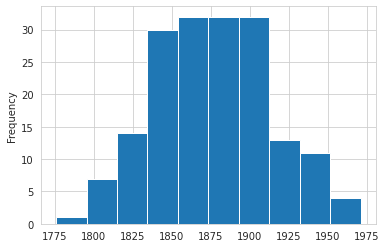

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
metadata.startdate.astype('int').plot(kind='hist')

In [ ]:
metadata.startdate.describe()

count      176
unique     105
top       1863
freq         7
Name: startdate, dtype: object

In [ ]:
metadata.startdate.astype('int').describe()


count     176.000000
mean     1875.738636
std        37.196926
min      1776.000000
25%      1847.000000
50%      1875.500000
75%      1898.250000
max      1971.000000
Name: startdate, dtype: float64

In [ ]:
metadata.startdate.cut

array(['1837', '1822', '1836', '1923', '1902', '1889', '1885', '1898',
       '1896', '1905', '1879', '1906', '1847', '1841', '1834', '1850',
       '1928', '1853', '1863', '1863', '1828', '1876', '1855', '1842',
       '1896', '1905', '1907', '1900', '1891', '1910', '1895', '1886',
       '1896', '1815', '1924', '1863', '1893', '1863', '1888', '1857',
       '1875', '1844', '1855', '1835', '1856', '1856', '1903', '1861',
       '1877', '1895', '1881', '1843', '1905', '1863', '1832', '1891',
       '1897', '1877', '1921', '1887', '1891', '1865', '1882', '1881',
       '1890', '1825', '1895', '1903', '1855', '1867', '1834', '1894',
       '1831', '1838', '1874', '1898', '1934', '1914', '1938', '1937',
       '1916', '1847', '1874', '1920', '1928', '1939', '1848', '1885',
       '1869', '1896', '1903', '1959', '1822', '1838', '1870', '1847',
       '1922', '1812', '1850', '1935', '1875', '1847', '1854', '1971',
       '1808', '1939', '1939', '1873', '1824', '1898', '1945', '1894',
      

In [ ]:
metadata.describe().style

,e_rara_id,title,name,gnd_person,notation_ddc,subject,gnd_topic,idsbb,gnd_topic_stw,gnd_geo,gnd_temp,dateissued,startdate,language,abstract,note
count,176,176,162,127,51,56,12,11,22,14,5,176,176,176,7,144
unique,176,174,143,108,24,40,11,10,9,5,2,129,105,3,7,143
top,5710847,Systematische Zusammenstellung der Medizinal-Gesetze des Kantons Bern,"['Zeerleder, Albert', '1838-1900']",['(DE-588)4005765-3; Kanton Bern'],['949.4'],['Bern'],['Juragewässerkorrektion'],['Ortsnamen; Bern (Kanton); Wörterbuch'],['Wasserbau'],['Bern'],['Geschichte'],1863,1863,['ger'],['Droschkentarife ; Eisenbahnfahrtaxen von und nach Bern aus der Schweiz und Europa'],['Berichterstatter: J. Heer']
freq,1,2,3,4,10,7,2,2,9,10,4,5,7,167,1,2


In [ ]:
metadata.subject.values[20:60]

array([None, None, None, list(['Wasserbau']), None, None, None, None,
       None,
       list(['Geschichte', 'Heimatkunde', 'Sage', 'Volkswirtschaft']),
       None, None, None, list(['Basel']), None, None, None, None, None,
       None, None, None, None, None, None,
       list(['Armenfürsorge; Bern (Kanton); Geschichte 19. Jh; Bericht', 'Armut']),
       None, None, None, None, None, list(['Wasserbau']), None,
       list(['Wasserbau']), list(['Panorama']), None, list(['Pflanzen']),
       list(['Geschichte']),
       list(['Geschichte 1300-1530', 'Handel', 'Messe', 'Veranstaltungswirtschaft']),
       list(['Volkswirtschaft'])], dtype=object)

In [ ]:
metadata.gnd_person.values[20:40]

array([None, list(['(DE-588)1034151711; Wyttenbach, Albert; 1833-1905']),
       list(['(DE-588)1048599094; Kaiser, Niklaus; 1806-1869']),
       list(['(DE-588)123642477; La Nicca, Richard; 1794-1883', '(DE-588)1085750035; Vorbereitungs-Gesellschaft für die Jura-Gewässer-Correction']),
       list(['(DE-588)117438189; Tuerler, Heinrich; 1861-1933']),
       list(['(DE-588)123794528,; Rodt, Eduard von; 1849-1926; Verfasser; aut']),
       list(['(DE-588)123794528,; Rodt, Eduard von; 1849-1926; Verfasser; aut']),
       list(['(DE-588)1012099-3; Historischer Verein des Kantons Bern']),
       list(['(DE-588)117166251,; Mülinen, Wolfgang Friedrich von; 1863-1917; Verfasser; aut']),
       list(['(DE-588)116498226; Hartmann, Hermann; 1865-1932', '(DE-588)5552820-X; Oberländischer Verkehrsverein']),
       None,
       list(['(DE-588)123794528,; Rodt, Eduard von; 1849-1926; Verfasser; aut']),
       list(['(DE-588)1137969385,; Kellerhals, Johann Otto; 1870-1945; Verfasser; aut', '(DE-588)8

In [ ]:
# maybe someday rather JSON?
    data = {
            'e_rara_identifier': e_rara_identifier,
            'title': title,
            'name': [name, role],
            'subject': subject,
            'notation_ddc': notation_ddc,
            'doi': doi,
            'issuance': issuance,
            'gnd_person': [gnd_person, gnd_identifier],
            'gnd_geo': gnd_geo,
            'gnd_topic': gnd_topic, 
            'idsbb': idsbb,
            'subject': subject,
            'language': language,
            'dateissued': dateissued,
            'accesscondition': accesscondition,
        }
        #print(json.dumps(data, ensure_ascii=False))
    print(data)

    #with open('filename', 'w', encoding='utf8') as json_file:
        #json.dump("ברי צקלה", json_file, ensure_ascii=False)
 

In [ ]:

dateiliste = os.listdir('./daten')

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(mets_analyse, dateiliste)

    for slub_id, seiten in results:
        liste.update({slub_id: seiten})


df = pd.DataFrame.from_dict(liste, orient='index', columns=['seiten'])

print(df)

# df.slub_id = f'{df.slub_id.str[:4]}-{df.slub_id.str[4:6]}-{df.slub_id.str[6:8]}'


df.to_csv("./seitenliste.csv", sep=',')


# df['slub-id'][:3].astype(str)

# df = pd.read_csv("seitenliste_clean.csv", delimiter=",")
# df.slub_id = df.slub_id.astype(str)
# df.slub_id = df.slub_id.str[:4] + '-' + df.slub_id.str[4:6] + '-' + df.slub_id.str[6:8]

finish = time.perf_counter()

print('Finished in {round(finish-start, 2)} second(s)')

## 3 Complimentary data

### 3.1 Authority data from lobid-gnd (GND, EntityFacts)

Documentation API: https://lobid.org/gnd/api  
Introduction to API: https://blog.lobid.org/2018/07/06/lobid-gnd-queries.html

Die GND enthält normierte Einträge u.a. für Personen, Körperschaften, Geografika. Sie wird von der Deutschen Nationalbibliothek (DNB), den deutschsprachigen Bibliotheksverbünden, der Zeitschriftendatenbank (ZDB) und zahlreichen weiteren Institutionen kooperativ geführt. Die Daten sind unter CC0 lizenziert.

lobid-gnd bietet eine Rechercheoberfläche zum Durchsuchen der GND, eine Integration in OpenRefine, sowie eine generelle Web-API auf Basis von JSON-LD zur Verwendung der Daten in verschiedenen Kontexten. Datenbasis sind die RDF-Version der GND (täglich aktualisiert) und EntityFacts (vierteljährlich aktualisiert).


In [ ]:
# Import the necessary Python libraries
import os     # for navigating the machine (e.g., file directories)
from datetime import datetime       # for working with dates and time
import codecs     # for encodings
import requests     # for requesting URLs
import json     # module for working with JSON data structures
import pandas as pd       # module for general data processing, esp. dataframes
print("Succesfully imported necessary modules")

Succesfully imported necessary modules


In [ ]:
# Enable file up- and download to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create folder path in Google Drive
%cd /content/drive/My\ Drive
!mkdir -p -- e_rara_complementary/lobid/
%cd /content/

/content/drive/My Drive
/content


In [ ]:
url = "https://lobid.org/gnd/search?q=geographicAreaCode.id%3A%22https%3A%2F%2Fd-nb.info%2Fstandards%2Fvocab%2Fgnd%2Fgeographic-area-code%23XA-CH-BE%22&filter=%2B%28type%3ATerritorialCorporateBodyOrAdministrativeUnit%29&size=600&format=json"
response = requests.get(url)
dump = response.json()

In [ ]:
# Save JSON file to Google Drive
date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
%cd /content/drive/My\ Drive/e_rara_complementary/lobid/
outfile = "./communities_BE_" + date + ".json"
with open(outfile, "w") as f:
    json.dump(dump, f)
    files.download(outfile)
%cd /content/
print("Saved JSON file to Google Drive.")

/content/drive/My Drive/e_rara_complementary/lobid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
Saved JSON file to Google Drive.


### 3.2 Reshape lobid-org natural units data

In [ ]:
# Read JSON file from Google Drive

infile = "/content/drive/My Drive/e_rara_complementary/lobid/naturalunits_BE_2021-03-16.json"
with open(infile, "r") as f:
    data = json.load(f)
df = pd.DataFrame(data["member"])

In [ ]:
# Convert the 'NaN' to 'None'
df = df.where(pd.notnull(df), None)

In [ ]:
# Overview of filled data fields
for c in df.columns:
    num_col = 0
    for i in df.index:
        if df[c][i] is not None:
            num_col += 1
    print('number of values in ' + c + ': ', num_col)

In [ ]:
df = df.drop(columns=df.columns[0:6])

In [ ]:
df = df.drop(columns=df.columns[1:2])

In [ ]:
df = df.drop(columns=df.columns[11:12])

In [ ]:
df = df.drop(columns=df.columns[13:19])

In [ ]:
df.shape

(273, 13)

In [ ]:
df

,broaderTermInstantial,gndIdentifier,id,preferredName,variantName,sameAs,relatedPlaceOrGeographicName,dateOfProduction,place,hasGeometry,definition,wikipedia
0,"{'id': 'https://d-nb.info/gnd/4184374-5', 'lab...",115019345X,https://d-nb.info/gnd/115019345X,Färmel,Färmeltal,{'id': 'http://viaf.org/viaf/67001515957844054...,None,None,None,None,Seitental des Obersimmentals bei Matten (St. S...,None
1,"{'id': 'https://d-nb.info/gnd/4127590-1', 'lab...",1167709160,https://d-nb.info/gnd/1167709160,Oberaarsee,None,{'id': 'http://viaf.org/viaf/42021538347518644...,"{'id': 'https://d-nb.info/gnd/4594353-9', 'lab...",1950-1954,"{'id': 'https://d-nb.info/gnd/4782351-3', 'lab...",None,Stausee im Quellgebiet der Aare im Kanton Bern...,None
2,"{'id': 'https://d-nb.info/gnd/4137668-7', 'lab...",1173755942,https://d-nb.info/gnd/1173755942,Rottalgletscher,None,{'id': 'http://viaf.org/viaf/38691545925127433...,"{'id': 'https://d-nb.info/gnd/4099108-8', 'lab...",None,None,None,"Gletscher im Jungfraugebiet, Gemeinde Lauterbr...",None
3,"{'id': 'https://d-nb.info/gnd/4189428-5', 'lab...",1184444552,https://d-nb.info/gnd/1184444552,Sängeliweiher,None,{'id': 'http://viaf.org/viaf/17155646084318210...,None,None,None,None,"Weiher südwestlich von Langenthal, Kanton Bern",None
4,"{'id': 'https://d-nb.info/gnd/4144619-7', 'lab...",1203452918,https://d-nb.info/gnd/1203452918,Gsür,None,"{'id': 'http://sws.geonames.org/6934806', 'col...",None,None,None,{'asWKT': ['Point ( +007.519444 +046.510555 )'...,2710 m hoher Berg nordwestlich von Adelboden,None
...,...,...,...,...,...,...,...,...,...,...,...,...
268,None,4091811-7,https://d-nb.info/gnd/4091811-7,Engstligenalp,Entschligenalp,"{'id': 'http://viaf.org/viaf/235930551', 'coll...",None,None,None,None,None,https://de.wikipedia.org/wiki/Engstligenalp
269,"{'id': 'https://d-nb.info/gnd/4184374-5', 'lab...",4055042-4,https://d-nb.info/gnd/4055042-4,Simmental,Simme / Tal,"{'id': 'http://viaf.org/viaf/240797912', 'coll...",None,None,None,None,"Talschaft der Simme, Berner Oberland",https://de.wikipedia.org/wiki/Simmental
270,"{'id': 'https://d-nb.info/gnd/4054084-4', 'lab...",4059993-0,https://d-nb.info/gnd/4059993-0,Thuner See,Thunersee,"{'id': 'http://viaf.org/viaf/242088849', 'coll...",None,None,None,None,None,https://de.wikipedia.org/wiki/Thunersee
271,"{'id': 'https://d-nb.info/gnd/4121454-7', 'lab...",7527843-1,https://d-nb.info/gnd/7527843-1,Strahleggpass,None,"{'id': 'http://viaf.org/viaf/233911182', 'coll...",None,None,None,None,Passübergang im Berner Oberland vom Strahleggg...,None


In [ ]:
# Get rid of useless '[]' in most fields
for c in df.columns:
    for i in df.index:
        if isinstance(df[c][i], list):
            df[c][i] = df[c][i][0]

In [ ]:
# Note: There is either 'biographicalOrHistoricalInformation' or 'definition', so it's presumably an equal information category.
# Therefore this fields can be merged
df.sort_values(by=['biographicalOrHistoricalInformation'], ascending=False).iloc[:,[4, 0, 11]].style

,preferredName,biographicalOrHistoricalInformation,definition
177,Lötschenpass,Übergang vom Kandertal (BE) ins Lötschental (VS),None
216,Napf (Berg),mit 1406 m ü. M. höchster Gipfel des Napfberglandes in den Emmentaler Alpen der Schweiz,None
82,Lüssel,etwa 21 km langer rechter Nebenfluss der Birs in den Schweizer Kantonen Basel-Landschaft und Solothurn,None
3,Sängeliweiher,"Weiher südwestlich von Langenthal, Kanton Bern",None
182,Giessbachfälle,"Wasserfälle des Bergbachs Giessbach, der über 14 Stufen 500m in die Tiefe stürzt und im Brienzersee mündet",None
149,Handegg-Fall,Wasserfall der Aare bei Handegg,None
113,Gasteretal,Tal im Berneroberland; mündet oberhalb Kandersteg ins Kandertal,None
1,Oberaarsee,"Stausee im Quellgebiet der Aare im Kanton Bern (Gemeinde Guttannen), unterhalb des Oberaargletschers",None
0,Färmel,Seitental des Obersimmentals bei Matten (St. Stephan),None
91,Wohlensee,"See im Kanton Bern, 1920 mit dem Bau des Wasserkraftwerks Mühleberg bei Niederruntigen entstanden",None


In [ ]:
for i in df.index:
    if df['definition'][i] is None:
            df['definition'][i] = df['biographicalOrHistoricalInformation'][i]
df = df.drop('biographicalOrHistoricalInformation', axis=1)

In [ ]:
for i in df.index:
    if df['wikipedia'][i] is not None:
            df['wikipedia'][i] = df.wikipedia[i].get('label')

In [ ]:
for i in df.index:
    if df['sameAs'][i] is not None:
            df['sameAs'][i] = df['sameAs'][i].get('id')

In [ ]:
df

,broaderTermInstantial,gndIdentifier,id,preferredName,variantName,sameAs,relatedPlaceOrGeographicName,dateOfProduction,place,hasGeometry,definition,wikipedia
0,"{'id': 'https://d-nb.info/gnd/4184374-5', 'lab...",115019345X,https://d-nb.info/gnd/115019345X,Färmel,Färmeltal,http://viaf.org/viaf/6700151595784405470008,None,None,None,None,Seitental des Obersimmentals bei Matten (St. S...,None
1,"{'id': 'https://d-nb.info/gnd/4127590-1', 'lab...",1167709160,https://d-nb.info/gnd/1167709160,Oberaarsee,None,http://viaf.org/viaf/4202153834751864450005,"{'id': 'https://d-nb.info/gnd/4594353-9', 'lab...",1950-1954,"{'id': 'https://d-nb.info/gnd/4782351-3', 'lab...",None,Stausee im Quellgebiet der Aare im Kanton Bern...,None
2,"{'id': 'https://d-nb.info/gnd/4137668-7', 'lab...",1173755942,https://d-nb.info/gnd/1173755942,Rottalgletscher,None,http://viaf.org/viaf/3869154592512743370001,"{'id': 'https://d-nb.info/gnd/4099108-8', 'lab...",None,None,None,"Gletscher im Jungfraugebiet, Gemeinde Lauterbr...",None
3,"{'id': 'https://d-nb.info/gnd/4189428-5', 'lab...",1184444552,https://d-nb.info/gnd/1184444552,Sängeliweiher,None,http://viaf.org/viaf/17155646084318210353,None,None,None,None,"Weiher südwestlich von Langenthal, Kanton Bern",None
4,"{'id': 'https://d-nb.info/gnd/4144619-7', 'lab...",1203452918,https://d-nb.info/gnd/1203452918,Gsür,None,http://sws.geonames.org/6934806,None,None,None,{'asWKT': ['Point ( +007.519444 +046.510555 )'...,2710 m hoher Berg nordwestlich von Adelboden,None
...,...,...,...,...,...,...,...,...,...,...,...,...
268,None,4091811-7,https://d-nb.info/gnd/4091811-7,Engstligenalp,Entschligenalp,http://viaf.org/viaf/235930551,None,None,None,None,None,https://de.wikipedia.org/wiki/Engstligenalp
269,"{'id': 'https://d-nb.info/gnd/4184374-5', 'lab...",4055042-4,https://d-nb.info/gnd/4055042-4,Simmental,Simme / Tal,http://viaf.org/viaf/240797912,None,None,None,None,"Talschaft der Simme, Berner Oberland",https://de.wikipedia.org/wiki/Simmental
270,"{'id': 'https://d-nb.info/gnd/4054084-4', 'lab...",4059993-0,https://d-nb.info/gnd/4059993-0,Thuner See,Thunersee,http://viaf.org/viaf/242088849,None,None,None,None,None,https://de.wikipedia.org/wiki/Thunersee
271,"{'id': 'https://d-nb.info/gnd/4121454-7', 'lab...",7527843-1,https://d-nb.info/gnd/7527843-1,Strahleggpass,None,http://viaf.org/viaf/233911182,None,None,None,None,Passübergang im Berner Oberland vom Strahleggg...,None


In [ ]:
df.relatedPlaceOrGeographicName[1]

{'id': 'https://d-nb.info/gnd/4594353-9', 'label': 'Grimsel-Gebiet'}

In [ ]:
df.broaderTermInstantial[2]

{'id': 'https://d-nb.info/gnd/4137668-7', 'label': 'Gletscher'}

In [ ]:
df.place[1]

{'id': 'https://d-nb.info/gnd/4782351-3', 'label': 'Guttannen'}

In [ ]:
df.hasGeometry[4]

{'asWKT': ['Point ( +007.519444 +046.510555 )'], 'type': 'Point'}

In [ ]:
df.sort_values(by=['preferredName'], ascending=False).iloc[:,[3, 4, 10]].style

,preferredName,variantName,definition
169,Öschinensee,Öschinen-See,None
183,Zulgtal,Zulg / Tal,Tal der Zulg im Berner Oberland
6,Zulg,None,"Fluss im Berner Oberland, fliesst bei Steffisburg in die Aare"
184,Zihl,LaThielle,linker Nebenfluss der Aare
252,Wunderbrunnen Engstlenalp,None,"Intermittierende Quelle, im 18. und 19. Jahrhundert ein beliebtes Reiseziel; im frühen Sommer ist die Quelle nur während drei bis vier Monate aktiv"
70,Worbletal,Worble / Tal,Tal bei Worb (Kt. Bern)
234,Worble,None,"Rechter Nebenfluss der Aare, entspringt bei Enggistein, durchfliesst Worb und mündet bei Worblaufen in die Aare"
91,Wohlensee,None,"See im Kanton Bern, 1920 mit dem Bau des Wasserkraftwerks Mühleberg bei Niederruntigen entstanden"
132,Wildstrubel-Gebiet,Wildstrubel (Region),None
129,Wildstrubel,None,Gebirgsgruppe in d. Berner Alpen


In [ ]:
date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
%cd /content/drive/My\ Drive/e_rara_complementary/lobid/
outfile = "./naturalunits_BE_" + date + ".csv"
with open(outfile, "w") as f:
    df.to_csv(f, index = False)
%cd /content/
print("Saved csv file to Google Drive.")

/content/drive/My Drive/e_rara_complementary/lobid
/content
Saved csv file to Google Drive.


### 3.3 Reshape lobid-org communities data

In [52]:
# Read JSON file from Google Drive

infile = "/content/drive/My Drive/e_rara_complementary/lobid/communities_BE_2021-03-16.json"
with open(infile, "r") as f:
    data = json.load(f)
df = pd.DataFrame(data["member"])

In [53]:
# Convert the 'NaN' to 'None'
df = df.where(pd.notnull(df), None)

In [54]:
df.shape

(599, 34)

In [55]:
# Overview of filling of data columns
for n, c in enumerate(df.columns):
    print(n, c)
    num = 0
    for i in df.index:
        if df[c][i] is not None:
            num += 1
    print('        ...has ', num, 'filled fields')

0 geographicAreaCode
        ...has  599 filled fields
1 relatedDdcWithDegreeOfDeterminacy2
        ...has  528 filled fields
2 describedBy
        ...has  599 filled fields
3 gndIdentifier
        ...has  599 filled fields
4 id
        ...has  599 filled fields
5 preferredName
        ...has  599 filled fields
6 wikipedia
        ...has  364 filled fields
7 type
        ...has  599 filled fields
8 variantName
        ...has  535 filled fields
9 @context
        ...has  599 filled fields
10 oldAuthorityNumber
        ...has  544 filled fields
11 sameAs
        ...has  599 filled fields
12 biographicalOrHistoricalInformation
        ...has  119 filled fields
13 hierarchicalSuperiorOfPlaceOrGeographicName
        ...has  101 filled fields
14 depiction
        ...has  289 filled fields
15 deprecatedUri
        ...has  300 filled fields
16 definition
        ...has  158 filled fields
17 homepage
        ...has  57 filled fields
18 dateOfEstablishment
        ...has  9 filled fields
19 broa

In [56]:
df = df.drop(columns=df.columns[0])

In [57]:
df = df.drop(columns=df.columns[1])

In [58]:
df = df.drop(columns=df.columns[7:9])

In [59]:
df = df.drop(columns=df.columns[11])

In [60]:
df.shape

(599, 29)

In [61]:
# Get rid of useless '[]'
for c in df.columns:
    for i in df.index:
        if isinstance(df[c][i], list):
            df[c][i] = df[c][i][0]

In [62]:
df.iloc[8,:]

relatedDdcWithDegreeOfDeterminacy2             {'id': 'http://dewey.info/class/2--494542/', '...
gndIdentifier                                                                         1060395177
id                                                              https://d-nb.info/gnd/1060395177
preferredName                                                               Vielbringen bei Worb
wikipedia                                                                                   None
type                                                TerritorialCorporateBodyOrAdministrativeUnit
variantName                                                           Worb- Vielbringen bei Worb
sameAs                                         {'id': 'http://viaf.org/viaf/311445962', 'coll...
biographicalOrHistoricalInformation                                                         None
hierarchicalSuperiorOfPlaceOrGeographicName    {'id': 'https://d-nb.info/gnd/4337206-5', 'lab...
depiction                     

In [63]:
# Note: 'biographicalOrHistoricalInformation' and 'definition' may contain different valuable
# information and can't be merged.
df.iloc[164:167,[8,11]].style

,biographicalOrHistoricalInformation,definition
164,None,None
165,"Die Gemeinden Gelterfingen, Mühledorf und Noflen planen Anfang 2018 mit der Gemeinde Kirchdorf zu fusionieren","Bis 2009 Gemeinde im Amtsbezirk Seftigen, ab 2010 Gemeinde im Verwaltungskreis Bern-Mittelland des Kt. Bern"
166,"Hauptort des Verwaltungskreises Oberaargau (bis 31.12.2009: Amtsbezirk Wangen), nach 1218 gegründet, 1313 Stadt urkundl. erwähnt",None


In [69]:
print(df.definition.describe())
print('---')
df.biographicalOrHistoricalInformation.describe()


count                         158
unique                        113
top       Gemeinde im Kanton Bern
freq                           16
Name: definition, dtype: object
---


count                                 119
unique                                102
top       Historische Gebietskörperschaft
freq                                    4
Name: biographicalOrHistoricalInformation, dtype: object

In [70]:
# Inspect 'wikipedia' field
for i in df.index[20:30]:
    print(df.wikipedia[i])
    print('---')

{'id': 'https://de.wikipedia.org/wiki/Clavaleyres', 'label': 'https://de.wikipedia.org/wiki/Clavaleyres'}
---
None
---
{'id': 'https://de.wikipedia.org/wiki/Schwadernau', 'label': 'https://de.wikipedia.org/wiki/Schwadernau'}
---
{'id': 'https://de.wikipedia.org/wiki/Freimettigen', 'label': 'https://de.wikipedia.org/wiki/Freimettigen'}
---
{'id': 'https://de.wikipedia.org/wiki/Monible', 'label': 'https://de.wikipedia.org/wiki/Monible'}
---
{'id': 'https://de.wikipedia.org/wiki/Noflen_BE', 'label': 'https://de.wikipedia.org/wiki/Noflen_BE'}
---
None
---
{'id': 'https://de.wikipedia.org/wiki/Gurbr%C3%BC', 'label': 'https://de.wikipedia.org/wiki/Gurbr%C3%BC'}
---
None
---
{'id': 'https://de.wikipedia.org/wiki/Rumendingen', 'label': 'https://de.wikipedia.org/wiki/Rumendingen'}
---


In [71]:
# Extract Wikipedia link in 'wikipedia'
for i in df.index:
    if df['wikipedia'][i] is not None:
            df['wikipedia'][i] = df.wikipedia[i].get('label')

In [72]:
# Inspect 'sameAs' field
for i in df.index[355:370]:
    print(df.sameAs[i].get('collection').get('abbr'))
    print(df.sameAs[i].get('id'))
    print('---')

VIAF
http://viaf.org/viaf/236114569
---
LC
http://id.loc.gov/rwo/agents/n83200905
---
VIAF
http://viaf.org/viaf/249235967
---
VIAF
http://viaf.org/viaf/245830152
---
VIAF
http://viaf.org/viaf/246280117
---
VIAF
http://viaf.org/viaf/234772683
---
VIAF
http://viaf.org/viaf/245830390
---
VIAF
http://viaf.org/viaf/248274714
---
LC
http://id.loc.gov/rwo/agents/no2011144554
---
VIAF
http://viaf.org/viaf/233776377
---
VIAF
http://viaf.org/viaf/236095317
---
VIAF
http://viaf.org/viaf/236096612
---
VIAF
http://viaf.org/viaf/240853567
---
VIAF
http://viaf.org/viaf/233742715
---
LC
http://id.loc.gov/rwo/agents/n91020401
---


In [73]:
# Extract sameAs link
for i in df.index:
    if df['sameAs'][i] is not None:
            df['sameAs'][i] = df['sameAs'][i].get('id')

In [74]:
for i in df.index[20:30]:
    print(df.relatedDdcWithDegreeOfDeterminacy2[i])
    print('---')

{'id': 'http://dewey.info/class/2--494542/', 'label': 'http://dewey.info/class/2--494542/'}
---
{'id': 'http://dewey.info/class/2--4945497/', 'label': 'http://dewey.info/class/2--4945497/'}
---
{'id': 'http://dewey.info/class/2--4945457/', 'label': 'http://dewey.info/class/2--4945457/'}
---
{'id': 'http://dewey.info/class/2--494542/', 'label': 'http://dewey.info/class/2--494542/'}
---
{'id': 'http://dewey.info/class/2--494547/', 'label': 'http://dewey.info/class/2--494547/'}
---
{'id': 'http://dewey.info/class/2--494542/', 'label': 'http://dewey.info/class/2--494542/'}
---
{'id': 'http://dewey.info/class/2--494542/', 'label': 'http://dewey.info/class/2--494542/'}
---
{'id': 'http://dewey.info/class/2--494542/', 'label': 'http://dewey.info/class/2--494542/'}
---
{'id': 'http://dewey.info/class/2--4945457/', 'label': 'http://dewey.info/class/2--4945457/'}
---
{'id': 'http://dewey.info/class/2--4945497/', 'label': 'http://dewey.info/class/2--4945497/'}
---


In [75]:
# Extract relatedDdcWithDegreeOfDeterminacy2 link
for i in df.index:
    if df['relatedDdcWithDegreeOfDeterminacy2'][i] is not None:
            df['relatedDdcWithDegreeOfDeterminacy2'][i] = df['relatedDdcWithDegreeOfDeterminacy2'][i].get('id')

In [83]:
df.sort_values('preferredName')

,relatedDdcWithDegreeOfDeterminacy2,gndIdentifier,id,preferredName,wikipedia,type,variantName,sameAs,biographicalOrHistoricalInformation,hierarchicalSuperiorOfPlaceOrGeographicName,depiction,definition,homepage,dateOfEstablishment,broaderTermPartitive,broaderTermInstantial,dateOfTermination,succeedingPlaceOrGeographicName,relatedPlaceOrGeographicName,relatedDdcWithDegreeOfDeterminacy4,hasGeometry,relatedDdcWithDegreeOfDeterminacy3,precedingPlaceOrGeographicName,gndSubjectCategory,relatedDdcWithDegreeOfDeterminacy1,place,relatedTerm,associatedDate,complexSeeReferenceSubject
129,http://dewey.info/class/2--4945453/,4084617-9,https://d-nb.info/gnd/4084617-9,Aarberg,https://de.wikipedia.org/wiki/Aarberg,AuthorityResource,Einwohnergemeinde Aarberg,http://viaf.org/viaf/240345287,None,None,{'thumbnail': 'https://commons.wikimedia.org/w...,Gemeinde im Kanton Bern,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
595,http://dewey.info/class/2--4945493/,4084620-9,https://d-nb.info/gnd/4084620-9,Aarwangen,https://de.wikipedia.org/wiki/Aarwangen,TerritorialCorporateBodyOrAdministrativeUnit,Gemeinde Aarwangen,http://viaf.org/viaf/246100178,None,None,{'thumbnail': 'https://commons.wikimedia.org/w...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,1119185327,https://d-nb.info/gnd/1119185327,Achseten,None,PlaceOrGeographicName,Frutigen-Achseten,http://viaf.org/viaf/2074147967349284200007,"Ortsteil von Frutigen, Kanton Bern","{'id': 'https://d-nb.info/gnd/4093359-3', 'lab...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
596,http://dewey.info/class/2--4945415/,4000471-5,https://d-nb.info/gnd/4000471-5,Adelboden,https://de.wikipedia.org/wiki/Adelboden,TerritorialCorporateBodyOrAdministrativeUnit,Gemeinde Adelboden,http://id.loc.gov/rwo/agents/n83052732,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
427,http://dewey.info/class/2--4945497/,7558698-8,https://d-nb.info/gnd/7558698-8,Aefligen,https://de.wikipedia.org/wiki/Aefligen,AuthorityResource,Gemeinde Aefligen,http://viaf.org/viaf/234810619,None,None,{'thumbnail': 'https://commons.wikimedia.org/w...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,http://dewey.info/class/2--494542/,4268539-4,https://d-nb.info/gnd/4268539-4,Zollikofen,https://de.wikipedia.org/wiki/Zollikofen,AuthorityResource,Einwohnergemeinde Zollikofen,http://viaf.org/viaf/168633089,None,None,{'thumbnail': 'https://commons.wikimedia.org/w...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
431,http://dewey.info/class/2--494542/,4680115-7,https://d-nb.info/gnd/4680115-7,Zuzwil (Kanton Bern),None,AuthorityResource,Gemeinde Zuzwil (Kanton Bern),http://viaf.org/viaf/234789036,None,None,None,None,None,None,"{'id': 'https://d-nb.info/gnd/4005765-3', 'lab...",None,None,None,None,None,None,None,None,None,None,None,None,None,None
254,http://dewey.info/class/2--4945412/,4068259-6,https://d-nb.info/gnd/4068259-6,Zweisimmen,https://de.wikipedia.org/wiki/Zweisimmen,AuthorityResource,Einwohnergemeinde Zweisimmen,http://viaf.org/viaf/238361599,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
146,http://dewey.info/class/2--4945416/,4713939-0,https://d-nb.info/gnd/4713939-0,Zwieselberg,https://de.wikipedia.org/wiki/Zwieselberg_BE,AuthorityResource,Einwohnergemeinde Zwieselberg,http://viaf.org/viaf/245851047,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [85]:
df.sort_values(by=['preferredName'], ascending=False).iloc[:,[3, 4, 18]].style

,preferredName,wikipedia,relatedPlaceOrGeographicName
97,Zäziwil,https://de.wikipedia.org/wiki/Z%C3%A4ziwil,None
146,Zwieselberg,https://de.wikipedia.org/wiki/Zwieselberg_BE,None
254,Zweisimmen,https://de.wikipedia.org/wiki/Zweisimmen,None
431,Zuzwil (Kanton Bern),None,None
65,Zollikofen,https://de.wikipedia.org/wiki/Zollikofen,None
541,Zimmerwald,https://de.wikipedia.org/wiki/Zimmerwald,None
253,Zielebach,https://de.wikipedia.org/wiki/Zielebach,None
291,Zauggenried,https://de.wikipedia.org/wiki/Zauggenried,None
21,Würzbrunnen,None,None
198,Wäckerschwend,None,None


In [86]:
date = datetime.now().strftime("%Y-%m-%d")     # get today's date in YYYY-MM-DD format
%cd /content/drive/My\ Drive/e_rara_complementary/lobid/
outfile = "./communities_BE_" + date + ".csv"
with open(outfile, "w") as f:
    df.to_csv(f, index = False)
%cd /content/
print("Saved csv file to Google Drive.")

/content/drive/My Drive/e_rara_complementary/lobid
/content
Saved csv file to Google Drive.
